# VISUAL TRANSFORMER TRAINING

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler
import torch.optim as optim

import os
os.chdir("..")
BASE_DIR = os.getcwd()

from utils.vit_2 import ViTClassifier, PneumoniaDataset
from utils.vit_utils import VitUtilities

### Define The Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTClassifier().to(device)

print("ViT Classifier Initialized!")

ViT Classifier Initialized!


### Define Dataset

In [ ]:
CLASS_NAMES = {"pneumonia": 0, "normal": 1}

train_dir = os.path.join(BASE_DIR, r"data\train")
val_dir = os.path.join(BASE_DIR, r"data\val")

train_dataset = PneumoniaDataset(train_dir, CLASS_NAMES)
val_dataset = PneumoniaDataset(val_dir, CLASS_NAMES)

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")

Training Samples: 11888, Validation Samples: 2972


### Define DataLoaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=8, sampler=RandomSampler(train_dataset), num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print(f"DataLoaders Created Successfully")

DataLoaders Created Successfully


### Load The Model (optional)

In [ ]:
model.load_state_dict(torch.load(os.path.join(BASE_DIR, r"model\vit_pneumonia_classifier_BESTEVER.pth"), map_location=torch.device('cpu')))
model.to(device)  
model.train()

ViTClassifier(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')


### Define Criterion and Optimizer

In [6]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW([
        {'params': model.vit.patch_embed.parameters(), 'lr': 1e-6}, 
        {'params': model.vit.blocks[:-6].parameters(), 'lr': 3e-5},  
        {'params': model.vit.blocks[-6:-3].parameters(), 'lr': 1e-4},
        {'params': model.vit.blocks[-3:].parameters(), 'lr': 3e-4},  
        {'params': model.vit.head.parameters(), 'lr': 1e-3}           
    ])

### Train The Model

In [ ]:
epochs = 10

VitUtilities.train_vit(model, train_loader, val_loader, optimizer, criterion, device, epochs)
torch.save(model.state_dict(), os.path.join(BASE_DIR, r"model\vit_pneumonia_classifier_BESTEVER.pth"))

print("Model Saved Successfully!")

Epoch 10/10 [Train]: 100%|██████████| 1486/1486 [10:19<00:00,  2.40it/s, loss=0.0859]


Training Complete!
Final Confusion Matrix:
[[1119   83]
 [ 123 1647]]
Model Saved Successfully!


### Prediction with Visualisation

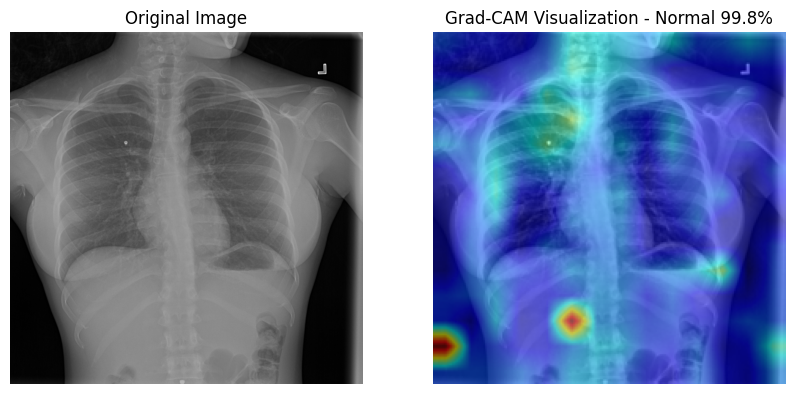

In [ ]:
image_path = os.path.join(BASE_DIR, r"data\val\normal\1a0aa05e-697c-40ba-a0c0-1dc64a913e3f.png")

VitUtilities.visualize_gradcam(model, image_path, device)

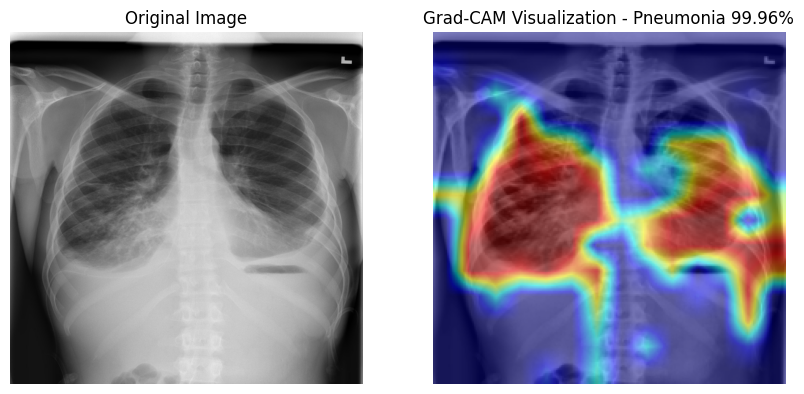

In [ ]:
image_path = os.path.join(BASE_DIR, r"data\val\pneumonia\2feb2bad-6b36-4067-87f1-54d39235e3c5.png")

VitUtilities.visualize_gradcam(model, image_path, device)